In [6]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from matplotlib import rcParams
import pickle,os
from importlib import reload
import sys
sys.path.append('../src')
import utils_enrich


cmap = sns.cm.rocket_r

def get_prob_single_clustering(df_clustering, clustering_column = 'Cluster genes'):
    '''
    df_clustering has in "clustering_column" a list of genes for each row, space separeted
    '''
    bins_size = df_clustering[clustering_column].str.split(' ').apply(len)
    n = bins_size.sum()
    p = ((bins_size/n)*((bins_size-1)/(n-1))).sum()
    return p


sig_edge_q=[.05,.95]
sig_edge_thresholds = None#[.15,.15]#[0,0]

N_REP=1000
str_name = str(sig_edge_q[-1]) if sig_edge_thresholds is None else str(sig_edge_thresholds[-1])
str_name = str_name + '_nrep_'+str(N_REP)
diff_alpha = 0.1#'nominal'#0.5
sig_alpha = 0.01#'nominal'#0.5
str_name = str(sig_edge_q[-1]) if sig_edge_thresholds is None else str(sig_edge_thresholds[-1])
str_name = str_name +'_sig_alpha_'+str(sig_alpha)+ '_diffalpha_'+str(diff_alpha)+ '_nrep_'+str(N_REP)

dir_pcorr_output = "../data/"
list_COPD_genes = ['FAM13A','HHIP','PPA2','BTC','TET2','NPNT','PPM1K','NAP1L5']


list_nreg = [0,1,5,10,25,50,75,100]
list_minL = [0,0.1,1,10]
chro = '4'#4'

df_cl_case = pd.DataFrame()
list_sig_case = []
df_info_nt = []
list_prob_cooc = []
df_gene_scores = pd.DataFrame()
for nreg in tqdm(list_nreg):
    for minL in list_minL:
        if nreg==0 and minL != 0:
            continue
        
        path_data = dir_pcorr_output+'/LTRC/nreg_%s_minL_%s_ch_%s/'%(nreg,minL,chro)
        path_file_clustering = path_data+ 'case_Clustering_MaxMod.csv'
        if not os.path.exists(path_file_clustering):
            print(path_file_clustering)
            continue

        new_df_cl_case = pd.read_csv(path_file_clustering,index_col=0)
        df_cl_case = pd.concat([df_cl_case,new_df_cl_case]) 
        list_sig_case.append(pd.read_csv(path_data+ 'Pcorr_significant_edges_nrep_%i_case.csv'%N_REP).values)
        g = nx.from_edgelist(list_sig_case[-1])
        lcc= max([len(x) for x in nx.connected_components(g)])
        density = nx.density(g)#2*g.number_of_nodes()/((N_GENES-1)*N_GENES)
        df_info_nt.append([nreg,minL,density,lcc])
        list_prob_cooc.append(get_prob_single_clustering(new_df_cl_case))
        
df_info_nt = pd.DataFrame(df_info_nt,columns = ['n_genes','min_lambda','density','LCC'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 22.66it/s]


### Figure 6: Partial Correlation Network topologies

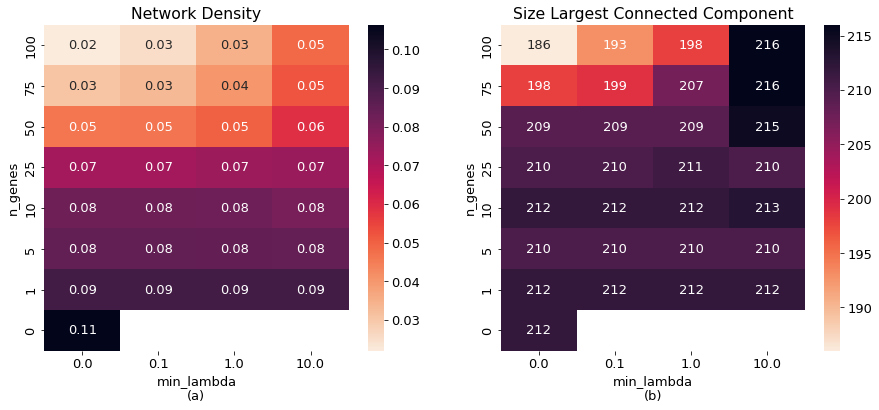

In [ ]:
rcParams.update({'font.size': 13})
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sns.heatmap(df_info_nt.pivot(index='n_genes',columns='min_lambda',values='density').sort_index(ascending=False),
           cmap=cmap,annot=True,fmt = '.2f')
plt.xlabel('min_lambda\n(a)')
plt.title('Network Density')
plt.subplot(1,2,2)
sns.heatmap(df_info_nt.pivot(index='n_genes',columns='min_lambda',values='LCC').sort_index(ascending=False),
           cmap=cmap,annot=True,fmt = '.0f')
plt.title('Size Largest Connected Component')
plt.xlabel('min_lambda\n(b)')
plt.savefig('../figures/Figure 4.pdf',dpi=500)



### Figure 7: Co-occurrence clustering heatmap

HHIP      0
BTC       0
NPNT      0
PPM1K     0
PPA2      3
TET2      3
FAM13A    4
NAP1L5    8
Name: Cluster, dtype: object

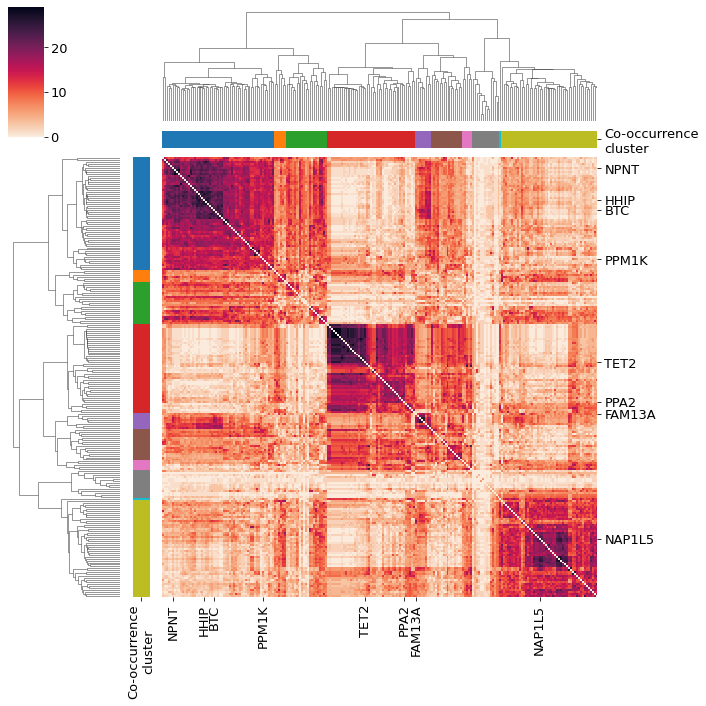

In [36]:
# build co-occurence matrix
import re
re_exp = r" "
vectorizer = CountVectorizer(tokenizer=lambda text: re.split(re_exp,text))
#vectorizer = CountVectorizer(token_pattern='(?u)\s\w\w+\s')
X = vectorizer.fit_transform(df_cl_case['Cluster genes'].values)
df_cooc = (X.T * X) # this is co-occurrence matrix in sparse csr format
df_cooc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
df_cooc = pd.DataFrame(df_cooc.todense(),index = vectorizer.get_feature_names_out(),columns= vectorizer.get_feature_names_out())
df_cooc.index = df_cooc.index.str.upper()
df_cooc.columns = df_cooc.columns.str.upper()

# retrieve hierarchical clusters using fcluster 
d = sch.distance.pdist(df_cooc)
L = sch.linkage(d, method='average')
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L,10,'maxclust')-1#.35*d.max(), 'distance')-1

palette = sns.color_palette(n_colors = len(set(clusters)))
tmp_colors = [palette[cl] for cl in  clusters]
df_cl = pd.DataFrame([clusters,tmp_colors],index = ['Cluster','Co-occurrence\ncluster'],columns = df_cooc.index).T
h = sns.clustermap(df_cooc,row_linkage=L, col_linkage=L,yticklabels=False,
                   row_colors=df_cl['Co-occurrence\ncluster'], col_colors=df_cl['Co-occurrence\ncluster'],
                  cmap=cmap)


reordered_labels = df_cl.index[h.dendrogram_row.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in list_COPD_genes]
h.ax_heatmap.set(yticks=use_ticks, yticklabels=list_COPD_genes,xticks=use_ticks, xticklabels=list_COPD_genes)

plt.savefig('../figures/Figure 5_Coclustering_all.pdf',dpi=500)
df_cl.loc[list_COPD_genes].Cluster.sort_values()


In [38]:
import gseapy as gp
tmp_cl = df_cl.loc['HHIP'].Cluster
gene_list = list(df_cl.query('Cluster ==@tmp_cl').index)

df_result = gp.enrichr(gene_list=list(tmp_genes),
                               gene_sets=['Epigenomics_Roadmap_HM_ChIP-seq','ENCODE_Histone_Modifications_2015'],
                               background=list(df_cooc.index),
                               verbose=False)

df_result = df_result.results.sort_values('Adjusted P-value').drop(
        ['Old adjusted P-value', 'Old P-value', 'Combined Score','P-value','Odds Ratio'], axis=1)
df_result = df_result[df_result['Adjusted P-value']<0.05]
#df_result['n_found']=df_result.Overlap.map(lambda x: x.split('/')[0])
df_result.Genes = df_result.Genes.str.replace(';', ' ')
df_result.Gene_set = df_result.Gene_set.str.replace('_', ' ')
df_result['CCG'] = df_result.Genes.map(lambda x: [y for y in x.split(' ') if y in list_COPD_genes])
df_result.head(20)

,Gene_set,Term,Adjusted P-value,Genes,CCG
0,Epigenomics Roadmap HM ChIP-seq,H3K27me3 Colonic Mucosa,1.002492e-08,CDS1 PARM1 SOWAHB HHIP SYNPO2 PRDM5 NDNF PKD2 ...,"[HHIP, NPNT, BTC]"
291,ENCODE Histone Modifications 2015,H3K27me3 fibroblast of lung hg19,5.150540e-04,CDS1 PARM1 SOWAHB HHIP CFI LEF1 SCD5 SETD7 SHR...,"[HHIP, NPNT, BTC]"
290,ENCODE Histone Modifications 2015,H3K9me3 CD14-positive monocyte hg19,5.150540e-04,PARM1 ANXA3 HHIP NDNF UNC5C NPNT PRSS12 TMEM15...,"[HHIP, NPNT, BTC]"
1,Epigenomics Roadmap HM ChIP-seq,H3K27me3 CD4+ CD25int CD127+ Tmem Primary Cells,8.430304e-04,SMAD1 ANXA3 HHIP SCD5 GAB1 SPP1 PRKG2 SPRY1 FA...,[HHIP]
293,ENCODE Histone Modifications 2015,H3K9me3 G1E-ER4 mm9,9.332565e-04,SMAD1 SOWAHB GAB1 SMARCA5 UNC5C NPNT PKD2 PTPN...,[NPNT]
292,ENCODE Histone Modifications 2015,H3K27me3 GM12878 hg19,9.332565e-04,CDS1 PARM1 SOWAHB ANXA3 HHIP LEF1 PRDM5 SETD7 ...,"[HHIP, NPNT, BTC]"
294,ENCODE Histone Modifications 2015,H3K27me3 A549 hg19,9.332565e-04,CDS1 PARM1 SYNPO2 ARHGEF38 SCD5 GAB1 ANK2 UNC5...,"[PPM1K, BTC]"
295,ENCODE Histone Modifications 2015,H3K27me3 spleen mm9,9.332565e-04,CDS1 SMAD1 PARM1 ANXA3 SYNPO2 GAB1 SHROOM3 UNC...,[]
296,ENCODE Histone Modifications 2015,H4K20me1 A549 hg19,9.332565e-04,CDS1 PARM1 SOWAHB HHIP GAB1 UNC5C PPM1K RAB33B...,"[HHIP, PPM1K]"
297,ENCODE Histone Modifications 2015,H3K27me3 thymus mm9,9.332565e-04,CDS1 SOWAHB ANXA3 SYNPO2 GAB1 SHROOM3 NDNF PKD...,[]


### Table 2: Co-occurrence CCG table - Binomial Distribution

In [32]:
from scipy.stats import binomtest, poisson

mu = sum(list_prob_cooc)
rv = poisson(mu)

df_poi_pval = df_cooc.loc[list_COPD_genes,list_COPD_genes].copy()
df_poi_pval.iloc[:,:] = 1-rv.cdf(df_poi_pval)
df_poi_pval

,FAM13A,HHIP,PPA2,BTC,TET2,NPNT,PPM1K,NAP1L5
FAM13A,0.999585,0.377696,0.377696,0.097139,0.257278,0.516878,0.996351,0.788426
HHIP,0.377696,0.999585,0.659875,0.000023,0.999585,0.000065,0.013925,0.887482
PPA2,0.377696,0.659875,0.999585,0.951088,0.006477,0.951088,0.887482,0.983763
BTC,0.097139,0.000023,0.951088,0.999585,0.996351,0.000007,0.054070,0.983763
TET2,0.257278,0.999585,0.006477,0.996351,0.999585,0.983763,0.659875,0.983763
NPNT,0.516878,0.000065,0.951088,0.000007,0.983763,0.999585,0.006477,0.788426
PPM1K,0.996351,0.013925,0.887482,0.054070,0.659875,0.006477,0.999585,0.983763
NAP1L5,0.788426,0.887482,0.983763,0.983763,0.983763,0.788426,0.983763,0.999585


In [33]:
df_cooc.loc[list_COPD_genes,list_COPD_genes].copy()

,FAM13A,HHIP,PPA2,BTC,TET2,NPNT,PPM1K,NAP1L5
FAM13A,0,8,8,11,9,7,1,5
HHIP,8,0,6,21,0,20,14,4
PPA2,8,6,0,3,15,3,4,2
BTC,11,21,3,0,1,22,12,2
TET2,9,0,15,1,0,2,6,2
NPNT,7,20,3,22,2,0,15,5
PPM1K,1,14,4,12,6,15,0,2
NAP1L5,5,4,2,2,2,5,2,0


In [34]:
from statsmodels.stats.multitest import multipletests

#print multiple test adjusted significant co-occurence of genes
np_poi_pval_adj = np.where(multipletests(df_poi_pval.values.reshape(-1),method = 'fdr_bh')[0].reshape(df_poi_pval.shape))
print('Statistically Significant co-occurrent genes (adj pval<.05)')
print('\n'.join([list_COPD_genes[x[0]] +'-'+ list_COPD_genes[x[1]] for x in zip(*np_poi_pval_adj)]))



Statistically Significant co-occurrent genes (adj pval<.05)
HHIP-BTC
HHIP-NPNT
PPA2-TET2
BTC-HHIP
BTC-NPNT
TET2-PPA2
NPNT-HHIP
NPNT-BTC
NPNT-PPM1K
PPM1K-NPNT
